# Tree based models

## Loading dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import Counter

# for feature engineering and model training
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import nltk

In [ ]:
# load data
###
with open('/content/drive/MyDrive/CS5228/emotions/data/processed/processed_text_balanced_w_punct.json', 'r') as f:
    data = json.load(f)
data = pd.DataFrame(data)
data.head()
# should contain 'text' and 'y' as columns
###

,s/n,diaID,uttID,split,y,sentiment,raw,clean,text,word_count,duration
0,1,0,0,dev,sadness,negative,"oh my god, he’s lost it. he’s totally lost it.","oh my god, he's lost it. he's totally lost it.","[oh, my, god, ,, he, be, lose, it, ., he, be, ...",15,3.0
1,2,0,1,dev,surprise,negative,what?,what?,"[what, ?]",2,2.0
2,3,1,0,dev,neutral,neutral,"or! or, we could go to the bank, close our acc...","or! or, we could go to the bank, close our acc...","[or, !, or, ,, we, could, go, to, the, bank, ,...",22,6.0
3,4,1,1,dev,joy,positive,you’re a genius!,you're a genius!,"[you, be, a, genius, !]",5,1.0
4,5,1,2,dev,sadness,negative,"aww, man, now we won’t be bank buddies!","aww, man, now we won't be bank buddies!","[aww, ,, man, ,, now, we, will, not, be, bank,...",12,3.0


In [ ]:
emotions = data.y.drop_duplicates().to_list()
emotions.remove('neutral')
emotions

['sadness', 'surprise', 'joy', 'anger', 'disgust', 'fear']

In [ ]:
# data.columns
print(data.sentiment.value_counts())
print(data.y.value_counts())

sentiment
negative    5641
neutral     3224
positive    3088
Name: count, dtype: int64
y
neutral     3224
joy         2308
surprise    1636
anger       1607
disgust     1088
fear        1088
sadness     1002
Name: count, dtype: int64


## Binary class classification

### JOY

In [ ]:
train_joy = data[(data.split == 'train') & (data.y.isin(['neutral', 'joy']))]
dev_joy = data[(data.split == 'dev') & (data.y.isin(['neutral', 'joy']))]
test_joy = data[(data.split == 'test') & (data.y.isin(['neutral', 'joy']))]
new_train_joy = data[(data.split.isin(['train', 'dev'])) & (data.y.isin(['neutral', 'joy']))]

X_train_joy = train_joy['clean']
y_train_joy = train_joy['y']

X_dev_joy = dev_joy['clean']
y_dev_joy = dev_joy['y']

X_test_joy = test_joy['clean']
y_test_joy = test_joy['y']

X_new_train_joy = new_train_joy['clean']
y_new_train_joy = new_train_joy['y']

vectorizer = TfidfVectorizer(stop_words = 'english', max_features = 1000)
X_train_joy = vectorizer.fit_transform(X_train_joy)

X_dev_joy = vectorizer.transform(X_dev_joy)
X_test_joy = vectorizer.transform(X_test_joy)
X_new_train_joy = vectorizer.transform(X_new_train_joy)

#### Decision Tree for 'JOY'

In [ ]:
best_f1 = 0
best_params = {}
criterion_lst = ['gini', 'entropy']
depth_lst = [5, 10, 15, 20]
weight_lst = [None, 'balanced']
sample_lst = [2, 5, 10]

for criterion in criterion_lst:
  for depth in depth_lst:
      for weight in weight_lst:
        for sample in sample_lst:
          model = DecisionTreeClassifier(max_depth = depth, criterion = criterion, class_weight = weight, min_samples_split = sample)
          model.fit(X_train_joy, y_train_joy)
          y_pred_joy = model.predict(X_dev_joy)
          acc = accuracy_score(y_dev_joy, y_pred_joy)
          f1 = f1_score(y_dev_joy, y_pred_joy, average = 'macro')
          # print('criterion:', criterion, 'max_depth:', depth, 'class_weight:', weight, 'Accuracy:', 'min_samples_split', sample, acc, 'F1-score:', f1)
          if f1 > best_f1:
              best_f1 = f1
              best_params = {'criterion': criterion, 'max_depth': depth, 'class_weight': weight, 'min_samples_split': sample}
print(best_params)


criterion: gini max_depth: 5 class_weight: None Accuracy: min_samples_split 2 0.7282780410742496 F1-score: 0.5813492063492063
criterion: gini max_depth: 5 class_weight: None Accuracy: min_samples_split 5 0.7282780410742496 F1-score: 0.5813492063492063
criterion: gini max_depth: 5 class_weight: None Accuracy: min_samples_split 10 0.7298578199052133 F1-score: 0.5825778113708144
criterion: gini max_depth: 5 class_weight: balanced Accuracy: min_samples_split 2 0.7282780410742496 F1-score: 0.5813492063492063
criterion: gini max_depth: 5 class_weight: balanced Accuracy: min_samples_split 5 0.7282780410742496 F1-score: 0.5813492063492063
criterion: gini max_depth: 5 class_weight: balanced Accuracy: min_samples_split 10 0.7282780410742496 F1-score: 0.5813492063492063
criterion: gini max_depth: 10 class_weight: None Accuracy: min_samples_split 2 0.7377567140600316 F1-score: 0.6092592592592592
criterion: gini max_depth: 10 class_weight: None Accuracy: min_samples_split 5 0.7393364928909952 F1-sc

In [ ]:
final_dt_joy = DecisionTreeClassifier(**best_params)
final_dt_joy.fit(X_new_train_joy, y_new_train_joy)
y_pred_dt_joy = final_dt_joy.predict(X_test_joy)
f1_dt_joy = f1_score(y_test_joy, y_pred_dt_joy, average = 'macro')
acc_dt_joy = accuracy_score(y_test_joy, y_pred_dt_joy)
pre_dt_joy = precision_score(y_test_joy, y_pred_dt_joy, pos_label = 'joy')
print('Accuracy:', acc_dt_joy, 'Precision:', pre_dt_joy, 'F1-score:', f1_dt_joy)

Accuracy: 0.7310012062726177 Precision: 0.43209876543209874 F1-score: 0.6067370794643523


##### Important Features

In [ ]:
feature_importances = final_dt.feature_importances_
feature_names = vectorizer.get_feature_names_out()
features = list(zip(feature_names, feature_importances))
features.sort(key = lambda x: -x[1])
for feature, importance in features[:10]:
    print(f"{feature}: {importance}")

oh: 0.10164822294788038
great: 0.08221278472295913
love: 0.05973323335734376
hi: 0.04366327299807648
hey: 0.035646984345086355
know: 0.03216252477115257
yeah: 0.03184877529896241
god: 0.029036727565478034
amazing: 0.027403109316475955
uh: 0.02684766653848356


Text(0.5, 1.0, 'Confusion matrix of DT')

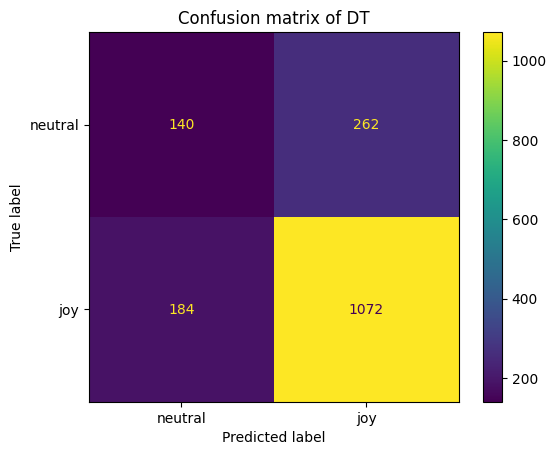

In [ ]:
cm = confusion_matrix(y_test_joy, y_pred_dt_joy, labels = None, sample_weight=None)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
      display_labels = list(y_test.unique()))
disp.plot()
plt.title('Confusion matrix of DT')

#### Random Forest for 'JOY'

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

best_f1 = 0
best_params = {}

n_estimators_list = [10, 50, 100]
criterion_list = ['gini', 'entropy']
max_depth_list = [5, 10, 15, None]
min_samples_split_list = [2, 5, 10]

for n_estimators in n_estimators_list:
    for criterion in criterion_list:
        for max_depth in max_depth_list:
            for min_samples_split in min_samples_split_list:
                model = RandomForestClassifier(n_estimators = n_estimators, criterion = criterion, max_depth = max_depth,
                                min_samples_split = min_samples_split, class_weight = 'balanced')
                model.fit(X_train_joy, y_train_joy)
                y_pred_joy = model.predict(X_dev_joy)

                acc = accuracy_score(y_dev_joy, y_pred_joy)
                f1 = f1_score(y_dev_joy, y_pred_joy, average='macro')

                # print(f'N_estimators: {n_estimators}, Criterion: {criterion}, Max_depth: {max_depth}, Min_samples_split: {min_samples_split}, Accuracy: {acc:.4f}, F1-score: {f1:.4f}')

                if f1 > best_f1:
                    best_f1 = f1
                    best_params = {'n_estimators': n_estimators, 'criterion': criterion, 'max_depth': max_depth, 'min_samples_split': min_samples_split}
print('Best F1 Score:', best_f1)
print('Best Parameters:', best_params)


final_rf_joy = RandomForestClassifier(**best_params)
final_rf_joy.fit(X_new_train_joy, y_new_train_joy)
y_pred_rf_joy = final_rf_joy.predict(X_test_joy)
f1_rf_joy = f1_score(y_test_joy, y_pred_rf_joy, average = 'macro')
acc_rf_joy = accuracy_score(y_test_joy, y_pred_rf_joy)
pre_rf_joy = precision_score(y_test_joy, y_pred_rf_joy, pos_label = 'joy')
print('Accuracy:', acc_rf_joy, 'Precision:', pre_rf_joy, 'F1-score:', f1_rf_joy)

feature_importances = final_rf_joy.feature_importances_
feature_names = vectorizer.get_feature_names_out()
features = list(zip(feature_names, feature_importances))
features.sort(key = lambda x: -x[1])
for feature, importance in features[:10]:
    print(f"{feature}: {importance}")

N_estimators: 10, Criterion: gini, Max_depth: 5, Min_samples_split: 2, Accuracy: 0.7488, F1-score: 0.5976
N_estimators: 10, Criterion: gini, Max_depth: 5, Min_samples_split: 5, Accuracy: 0.7172, F1-score: 0.5885
N_estimators: 10, Criterion: gini, Max_depth: 5, Min_samples_split: 10, Accuracy: 0.7141, F1-score: 0.5981
N_estimators: 10, Criterion: gini, Max_depth: 10, Min_samples_split: 2, Accuracy: 0.6919, F1-score: 0.5897
N_estimators: 10, Criterion: gini, Max_depth: 10, Min_samples_split: 5, Accuracy: 0.7188, F1-score: 0.6076
N_estimators: 10, Criterion: gini, Max_depth: 10, Min_samples_split: 10, Accuracy: 0.7267, F1-score: 0.6230
N_estimators: 10, Criterion: gini, Max_depth: 15, Min_samples_split: 2, Accuracy: 0.7093, F1-score: 0.6273
N_estimators: 10, Criterion: gini, Max_depth: 15, Min_samples_split: 5, Accuracy: 0.7172, F1-score: 0.6234
N_estimators: 10, Criterion: gini, Max_depth: 15, Min_samples_split: 10, Accuracy: 0.7077, F1-score: 0.6124
N_estimators: 10, Criterion: gini, Ma

### SADNESS

In [ ]:
train_sad = data[(data.split == 'train') & (data.y.isin(['neutral', 'sadness']))]
dev_sad = data[(data.split == 'dev') & (data.y.isin(['neutral', 'sadness']))]
test_sad = data[(data.split == 'test') & (data.y.isin(['neutral', 'sadness']))]
new_train_sad = data[(data.split.isin(['train', 'dev'])) & (data.y.isin(['neutral', 'sadness']))]

X_train_sad = train_sad['clean']
y_train_sad = train_sad['y']

X_dev_sad = dev_sad['clean']
y_dev_sad = dev_sad['y']

X_test_sad = test_sad['clean']
y_test_sad = test_sad['y']

X_new_train_sad = new_train_sad['clean']
y_new_train_sad = new_train_sad['y']

vectorizer = TfidfVectorizer(stop_words = 'english', max_features = 1000)
X_train_sad = vectorizer.fit_transform(X_train_sad)

X_dev_sad = vectorizer.transform(X_dev_sad)
X_test_sad = vectorizer.transform(X_test_sad)
X_new_train_sad = vectorizer.transform(X_new_train_sad)

#### Decision Tree for 'SADNESS'

In [ ]:
best_f1 = 0
best_params = {}
criterion_lst = ['gini', 'entropy']
depth_lst = [5, 10, 15, 20]
weight_lst = [None, 'balanced']
sample_lst = [2, 5, 10]

for criterion in criterion_lst:
  for depth in depth_lst:
      for weight in weight_lst:
        for sample in sample_lst:
          model = DecisionTreeClassifier(max_depth = depth, criterion = criterion, class_weight = weight, min_samples_split = sample)
          model.fit(X_train_sad, y_train_sad)
          y_pred_sad = model.predict(X_dev_sad)
          acc = accuracy_score(y_dev_sad, y_pred_sad)
          f1 = f1_score(y_dev_sad, y_pred_sad, average = 'macro')
          # print('criterion:', criterion, 'max_depth:', depth, 'class_weight:', weight, 'Accuracy:', 'min_samples_split', sample, acc, 'F1-score:', f1)
          if f1 > best_f1:
              best_f1 = f1
              best_params = {'criterion': criterion, 'max_depth': depth, 'class_weight': weight, 'min_samples_split': sample}
print(best_params)


criterion: gini max_depth: 5 class_weight: None Accuracy: min_samples_split 2 0.8158347676419966 F1-score: 0.5973040025392384
criterion: gini max_depth: 5 class_weight: None Accuracy: min_samples_split 5 0.8175559380378657 F1-score: 0.5988405419489318
criterion: gini max_depth: 5 class_weight: None Accuracy: min_samples_split 10 0.8192771084337349 F1-score: 0.6048310305291591
criterion: gini max_depth: 5 class_weight: balanced Accuracy: min_samples_split 2 0.8072289156626506 F1-score: 0.566394797164028
criterion: gini max_depth: 5 class_weight: balanced Accuracy: min_samples_split 5 0.8072289156626506 F1-score: 0.566394797164028
criterion: gini max_depth: 5 class_weight: balanced Accuracy: min_samples_split 10 0.8072289156626506 F1-score: 0.566394797164028
criterion: gini max_depth: 10 class_weight: None Accuracy: min_samples_split 2 0.8296041308089501 F1-score: 0.6189204767552025
criterion: gini max_depth: 10 class_weight: None Accuracy: min_samples_split 5 0.8313253012048193 F1-score

In [ ]:
final_dt_sad = DecisionTreeClassifier(**best_params)
final_dt_sad.fit(X_new_train_sad, y_new_train_sad)
y_pred_dt_sad = final_dt_sad.predict(X_test_sad)
f1_dt_sad = f1_score(y_test_sad, y_pred_dt_sad, average = 'macro')
acc_dt_sad = accuracy_score(y_test_sad, y_pred_dt_sad)
pre_dt_sad = precision_score(y_test_sad, y_pred_dt_sad, pos_label = 'sadness')
print('Accuracy:', acc_dt_sad, 'Precision:', pre_dt_sad, 'F1-score:', f1_dt_sad)

Accuracy: 0.7397540983606558 Precision: 0.23547400611620795 F1-score: 0.5643180460142706


##### Important Features

In [ ]:
feature_importances = final_dt_sad.feature_importances_
feature_names = vectorizer.get_feature_names_out()
features = list(zip(feature_names, feature_importances))
features.sort(key = lambda x: -x[1])
for feature, importance in features[:10]:
    print(f"{feature}: {importance}")

sorry: 0.14232457366822304
okay: 0.042570001536244274
god: 0.04169424785887213
hey: 0.04028648168615473
gonna: 0.03994852108167355
yeah: 0.034741960432346994
right: 0.03285700648066183
oh: 0.0328035140290849
just: 0.03231790022436084
don: 0.03184467588345741


#### Random Forest for 'SADNESS'

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

best_f1 = 0
best_params = {}

n_estimators_list = [10, 50, 100]
criterion_list = ['gini', 'entropy']
max_depth_list = [5, 10, 15, None]
min_samples_split_list = [2, 5, 10]

for n_estimators in n_estimators_list:
    for criterion in criterion_list:
        for max_depth in max_depth_list:
            for min_samples_split in min_samples_split_list:
                model = RandomForestClassifier(n_estimators = n_estimators, criterion = criterion, max_depth = max_depth,
                                min_samples_split = min_samples_split, class_weight = 'balanced')
                model.fit(X_train_sad, y_train_sad)
                y_pred_sad = model.predict(X_dev_sad)

                acc = accuracy_score(y_dev_sad, y_pred_sad)
                f1 = f1_score(y_dev_sad, y_pred_sad, average='macro')

                # print(f'N_estimators: {n_estimators}, Criterion: {criterion}, Max_depth: {max_depth}, Min_samples_split: {min_samples_split}, Accuracy: {acc:.4f}, F1-score: {f1:.4f}')

                if f1 > best_f1:
                    best_f1 = f1
                    best_params = {'n_estimators': n_estimators, 'criterion': criterion, 'max_depth': max_depth, 'min_samples_split': min_samples_split}
print('Best F1 Score:', best_f1)
print('Best Parameters:', best_params)


final_rf_sad = RandomForestClassifier(**best_params)
final_rf_sad.fit(X_new_train_sad, y_new_train_sad)
y_pred_rf_sad = final_rf_sad.predict(X_test_sad)
f1_rf_sad = f1_score(y_test_sad, y_pred_rf_sad, average = 'macro')
acc_rf_sad = accuracy_score(y_test_sad, y_pred_rf_sad)
pre_rf_sad = precision_score(y_test_sad, y_pred_rf_sad, pos_label = 'sadness')
print('Accuracy:', acc_rf_sad, 'Precision:', pre_rf_sad, 'F1-score:', f1_rf_sad)

feature_importances = final_rf_sad.feature_importances_
feature_names = vectorizer.get_feature_names_out()
features = list(zip(feature_names, feature_importances))
features.sort(key = lambda x: -x[1])
for feature, importance in features[:10]:
    print(f"{feature}: {importance}")

N_estimators: 10, Criterion: gini, Max_depth: 5, Min_samples_split: 2, Accuracy: 0.7745, F1-score: 0.6528
N_estimators: 10, Criterion: gini, Max_depth: 5, Min_samples_split: 5, Accuracy: 0.7694, F1-score: 0.6503
N_estimators: 10, Criterion: gini, Max_depth: 5, Min_samples_split: 10, Accuracy: 0.3873, F1-score: 0.3850
N_estimators: 10, Criterion: gini, Max_depth: 10, Min_samples_split: 2, Accuracy: 0.7814, F1-score: 0.6634
N_estimators: 10, Criterion: gini, Max_depth: 10, Min_samples_split: 5, Accuracy: 0.7539, F1-score: 0.6467
N_estimators: 10, Criterion: gini, Max_depth: 10, Min_samples_split: 10, Accuracy: 0.7780, F1-score: 0.6537
N_estimators: 10, Criterion: gini, Max_depth: 15, Min_samples_split: 2, Accuracy: 0.7349, F1-score: 0.6142
N_estimators: 10, Criterion: gini, Max_depth: 15, Min_samples_split: 5, Accuracy: 0.7487, F1-score: 0.6280
N_estimators: 10, Criterion: gini, Max_depth: 15, Min_samples_split: 10, Accuracy: 0.7642, F1-score: 0.6597
N_estimators: 10, Criterion: gini, Ma

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### SURPRISE

In [ ]:
train_sur = data[(data.split == 'train') & (data.y.isin(['neutral', 'surprise']))]
dev_sur = data[(data.split == 'dev') & (data.y.isin(['neutral', 'surprise']))]
test_sur = data[(data.split == 'test') & (data.y.isin(['neutral', 'surprise']))]
new_train_sur = data[(data.split.isin(['train', 'dev'])) & (data.y.isin(['neutral', 'surprise']))]

X_train_sur = train_sur['clean']
y_train_sur = train_sur['y']

X_dev_sur = dev_sur['clean']
y_dev_sur = dev_sur['y']

X_test_sur = test_sur['clean']
y_test_sur = test_sur['y']

X_new_train_sur = new_train_sur['clean']
y_new_train_sur = new_train_sur['y']

vectorizer = TfidfVectorizer(stop_words = 'english', max_features = 1000)
X_train_sur = vectorizer.fit_transform(X_train_sur)

X_dev_sur = vectorizer.transform(X_dev_sur)
X_test_sur = vectorizer.transform(X_test_sur)
X_new_train_sur = vectorizer.transform(X_new_train_sur)


DecisionTreeClassifier()

#### Decision Tree for 'SURPRISE'

In [ ]:
best_f1 = 0
best_params = {}
criterion_lst = ['gini', 'entropy']
depth_lst = [5, 10, 15, 20]
weight_lst = [None, 'balanced']
sample_lst = [2, 5, 10]

for criterion in criterion_lst:
  for depth in depth_lst:
      for weight in weight_lst:
        for sample in sample_lst:
          model = DecisionTreeClassifier(max_depth = depth, criterion = criterion, class_weight = weight, min_samples_split = sample)
          model.fit(X_train_sur, y_train_sur)
          y_pred_sur = model.predict(X_dev_sur)
          acc = accuracy_score(y_dev_sur, y_pred_sur)
          f1 = f1_score(y_dev_sur, y_pred_sur, average = 'macro')
          # print('criterion:', criterion, 'max_depth:', depth, 'class_weight:', weight, 'Accuracy:', 'min_samples_split', sample, acc, 'F1-score:', f1)
          if f1 > best_f1:
              best_f1 = f1
              best_params = {'criterion': criterion, 'max_depth': depth, 'class_weight': weight, 'min_samples_split': sample}
print(best_params)


criterion: gini max_depth: 5 class_weight: None Accuracy: min_samples_split 2 0.7935483870967742 F1-score: 0.5721463845938194
criterion: gini max_depth: 5 class_weight: None Accuracy: min_samples_split 5 0.7951612903225806 F1-score: 0.5775184439973172
criterion: gini max_depth: 5 class_weight: None Accuracy: min_samples_split 10 0.7951612903225806 F1-score: 0.5775184439973172
criterion: gini max_depth: 5 class_weight: balanced Accuracy: min_samples_split 2 0.7951612903225806 F1-score: 0.5775184439973172
criterion: gini max_depth: 5 class_weight: balanced Accuracy: min_samples_split 5 0.7935483870967742 F1-score: 0.5721463845938194
criterion: gini max_depth: 5 class_weight: balanced Accuracy: min_samples_split 10 0.7935483870967742 F1-score: 0.5721463845938194
criterion: gini max_depth: 10 class_weight: None Accuracy: min_samples_split 2 0.7951612903225806 F1-score: 0.6259577884291082
criterion: gini max_depth: 10 class_weight: None Accuracy: min_samples_split 5 0.7935483870967742 F1-sc

In [ ]:
final_dt_sur = DecisionTreeClassifier(**best_params)
final_dt_sur.fit(X_new_train_sur, y_new_train_sur)
y_pred_dt_sur = final_dt_sur.predict(X_test_sur)
f1_dt_sur = f1_score(y_test_sur, y_pred_dt_sur, average = 'macro')
acc_dt_sur = accuracy_score(y_test_sur, y_pred_dt_sur)
pre_dt_sur = precision_score(y_test_sur, y_pred_dt_sur, pos_label = 'surprise')
print('Accuracy:', acc_dt_sur, 'Precision:', pre_dt_sur, 'F1-score:', f1_dt_sur)

Accuracy: 0.8204294079375407 Precision: 0.515527950310559 F1-score: 0.635351194487615


##### Important Features

In [ ]:
feature_importances = final_dt_sur.feature_importances_
feature_names = vectorizer.get_feature_names_out()
features = list(zip(feature_names, feature_importances))
features.sort(key = lambda x: -x[1])
for feature, importance in features[:10]:
    print(f"{feature}: {importance}")

god: 0.13946129294774703
wow: 0.0724801999711833
really: 0.06679063438181157
okay: 0.05834311097856538
oh: 0.056110023014573525
yeah: 0.05385635540077021
whoa: 0.045879863719673786
know: 0.04042554598096946
right: 0.027118966211095916
ll: 0.024821719165156967


#### Random forest for 'SURPRISE'

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

best_f1 = 0
best_params = {}

n_estimators_list = [10, 50, 100]
criterion_list = ['gini', 'entropy']
max_depth_list = [5, 10, 15, None]
min_samples_split_list = [2, 5, 10]

for n_estimators in n_estimators_list:
    for criterion in criterion_list:
        for max_depth in max_depth_list:
            for min_samples_split in min_samples_split_list:
                model = RandomForestClassifier(n_estimators = n_estimators, criterion = criterion, max_depth = max_depth,
                                min_samples_split = min_samples_split, class_weight = 'balanced')
                model.fit(X_train_sur, y_train_sur)
                y_pred_sur = model.predict(X_dev_sur)

                acc = accuracy_score(y_dev_sur, y_pred_sur)
                f1 = f1_score(y_dev_sur, y_pred_sur, average='macro')

                # print(f'N_estimators: {n_estimators}, Criterion: {criterion}, Max_depth: {max_depth}, Min_samples_split: {min_samples_split}, Accuracy: {acc:.4f}, F1-score: {f1:.4f}')

                if f1 > best_f1:
                    best_f1 = f1
                    best_params = {'n_estimators': n_estimators, 'criterion': criterion, 'max_depth': max_depth, 'min_samples_split': min_samples_split}
print('Best F1 Score:', best_f1)
print('Best Parameters:', best_params)


N_estimators: 10, Criterion: gini, Max_depth: 5, Min_samples_split: 2, Accuracy: 0.4355, F1-score: 0.4355
N_estimators: 10, Criterion: gini, Max_depth: 5, Min_samples_split: 5, Accuracy: 0.4871, F1-score: 0.4840
N_estimators: 10, Criterion: gini, Max_depth: 5, Min_samples_split: 10, Accuracy: 0.5113, F1-score: 0.5062
N_estimators: 10, Criterion: gini, Max_depth: 10, Min_samples_split: 2, Accuracy: 0.5435, F1-score: 0.5339
N_estimators: 10, Criterion: gini, Max_depth: 10, Min_samples_split: 5, Accuracy: 0.7758, F1-score: 0.6549
N_estimators: 10, Criterion: gini, Max_depth: 10, Min_samples_split: 10, Accuracy: 0.5661, F1-score: 0.5543
N_estimators: 10, Criterion: gini, Max_depth: 15, Min_samples_split: 2, Accuracy: 0.5984, F1-score: 0.5802
N_estimators: 10, Criterion: gini, Max_depth: 15, Min_samples_split: 5, Accuracy: 0.5710, F1-score: 0.5575
N_estimators: 10, Criterion: gini, Max_depth: 15, Min_samples_split: 10, Accuracy: 0.6048, F1-score: 0.5864
N_estimators: 10, Criterion: gini, Ma

In [ ]:
final_rf_sur = RandomForestClassifier(**best_params)
final_rf_sur.fit(X_new_train_sur, y_new_train_sur)
y_pred_rf_sur = final_rf_sur.predict(X_test_sur)
f1_rf_sur = f1_score(y_test_sur, y_pred_rf_sur, average = 'macro')
acc_rf_sur = accuracy_score(y_test_sur, y_pred_rf_sur)
pre_rf_sur = precision_score(y_test_sur, y_pred_rf_sur, pos_label = 'surprise')
print('Accuracy:', acc_rf_sur, 'Precision:', pre_rf_sur, 'F1-score:', f1_rf_sur)

Accuracy: 0.8334417696811971 Precision: 0.9629629629629629 F1-score: 0.5381393732803711


In [ ]:
feature_importances = final_rf_sur.feature_importances_
feature_names = vectorizer.get_feature_names_out()
features = list(zip(feature_names, feature_importances))
features.sort(key = lambda x: -x[1])
for feature, importance in features[:10]:
    print(f"{feature}: {importance}")

life: 0.1171594266780499
pretty: 0.08151434454636694
falling: 0.07032190555747488
won: 0.04618089184859103
waiters: 0.04438867401830619
like: 0.04302856290364491
beans: 0.041152357987194146
working: 0.03313492480323374
hi: 0.02820677598713937
house: 0.027069752884988897


### ANGER

In [ ]:
train_anger = data[(data.split == 'train') & (data.y.isin(['neutral', 'anger']))]
dev_anger = data[(data.split == 'dev') & (data.y.isin(['neutral', 'anger']))]
test_anger = data[(data.split == 'test') & (data.y.isin(['neutral', 'anger']))]
new_train_anger = data[(data.split.isin(['train', 'dev'])) & (data.y.isin(['neutral', 'anger']))]

X_train_anger = train_anger['clean']
y_train_anger = train_anger['y']

X_dev_anger = dev_anger['clean']
y_dev_anger = dev_anger['y']

X_test_anger = test_anger['clean']
y_test_anger = test_anger['y']

X_new_train_anger = new_train_anger['clean']
y_new_train_anger = new_train_anger['y']

vectorizer = TfidfVectorizer(stop_words = 'english', max_features = 1000)
X_train_anger = vectorizer.fit_transform(X_train_anger)

X_dev_anger = vectorizer.transform(X_dev_anger)
X_test_anger = vectorizer.transform(X_test_anger)
X_new_train_anger = vectorizer.transform(X_new_train_anger)


DecisionTreeClassifier()

#### Decision Tree for 'ANGER'

In [ ]:
best_f1 = 0
best_params = {}
criterion_lst = ['gini', 'entropy']
depth_lst = [5, 10, 15, 20]
weight_lst = [None, 'balanced']
sample_lst = [2, 5, 10]

for criterion in criterion_lst:
  for depth in depth_lst:
      for weight in weight_lst:
        for sample in sample_lst:
          model = DecisionTreeClassifier(max_depth = depth, criterion = criterion, class_weight = weight, min_samples_split = sample)
          model.fit(X_train_anger, y_train_anger)
          y_pred_anger = model.predict(X_dev_anger)
          acc = accuracy_score(y_dev_anger, y_pred_anger)
          f1 = f1_score(y_dev_anger, y_pred_anger, average = 'macro')
          # print('criterion:', criterion, 'max_depth:', depth, 'class_weight:', weight, 'Accuracy:', 'min_samples_split', sample, acc, 'F1-score:', f1)
          if f1 > best_f1:
              best_f1 = f1
              best_params = {'criterion': criterion, 'max_depth': depth, 'class_weight': weight, 'min_samples_split': sample}
print(best_params)


criterion: gini max_depth: 5 class_weight: None Accuracy: min_samples_split 2 0.7656500802568218 F1-score: 0.5259641442568271
criterion: gini max_depth: 5 class_weight: None Accuracy: min_samples_split 5 0.7656500802568218 F1-score: 0.5259641442568271
criterion: gini max_depth: 5 class_weight: None Accuracy: min_samples_split 10 0.7656500802568218 F1-score: 0.5259641442568271
criterion: gini max_depth: 5 class_weight: balanced Accuracy: min_samples_split 2 0.3402889245585875 F1-score: 0.32922832690206927
criterion: gini max_depth: 5 class_weight: balanced Accuracy: min_samples_split 5 0.3402889245585875 F1-score: 0.32922832690206927
criterion: gini max_depth: 5 class_weight: balanced Accuracy: min_samples_split 10 0.3402889245585875 F1-score: 0.32922832690206927
criterion: gini max_depth: 10 class_weight: None Accuracy: min_samples_split 2 0.7720706260032103 F1-score: 0.5512984378170014
criterion: gini max_depth: 10 class_weight: None Accuracy: min_samples_split 5 0.7720706260032103 F1

In [ ]:
final_dt_anger = DecisionTreeClassifier(**best_params)
final_dt_anger.fit(X_new_train_anger, y_new_train_anger)
y_pred_dt_anger = final_dt_anger.predict(X_test_anger)
f1_dt_anger = f1_score(y_test_anger, y_pred_dt_anger, average = 'macro')
acc_dt_anger = accuracy_score(y_test_anger, y_pred_dt_anger)
pre_dt_anger = precision_score(y_test_anger, y_pred_dt_anger, pos_label = 'anger')
print('Accuracy:', acc_dt_anger, 'Precision:', pre_dt_anger, 'F1-score:', f1_dt_anger)

Accuracy: 0.749531542785759 Precision: 0.3055555555555556 F1-score: 0.5160761221626993


##### Important Features

In [ ]:
feature_importances = final_dt_anger.feature_importances_
feature_names = vectorizer.get_feature_names_out()
features = list(zip(feature_names, feature_importances))
features.sort(key = lambda x: -x[1])
for feature, importance in features[:10]:
    print(f"{feature}: {importance}")

don: 0.0667012435855384
yeah: 0.06569547255636232
okay: 0.0455968126142381
man: 0.04219286967968101
stupid: 0.04057095961300489
stop: 0.03599308004539862
know: 0.030802323749250234
uh: 0.028137636117526094
believe: 0.026855724663311216
ross: 0.025362138086101514


#### Random Forest for 'ANGER'

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

best_f1 = 0
best_params = {}

n_estimators_list = [10, 50, 100]
criterion_list = ['gini', 'entropy']
max_depth_list = [5, 10, 15, None]
min_samples_split_list = [2, 5, 10]

for n_estimators in n_estimators_list:
    for criterion in criterion_list:
        for max_depth in max_depth_list:
            for min_samples_split in min_samples_split_list:
                model = RandomForestClassifier(n_estimators = n_estimators, criterion = criterion, max_depth = max_depth,
                                min_samples_split = min_samples_split, class_weight = 'balanced')
                model.fit(X_train_anger, y_train_anger)
                y_pred_anger = model.predict(X_dev_anger)

                acc = accuracy_score(y_dev_anger, y_pred_anger)
                f1 = f1_score(y_dev_anger, y_pred_anger, average='macro')

                # print(f'N_estimators: {n_estimators}, Criterion: {criterion}, Max_depth: {max_depth}, Min_samples_split: {min_samples_split}, Accuracy: {acc:.4f}, F1-score: {f1:.4f}')

                if f1 > best_f1:
                    best_f1 = f1
                    best_params = {'n_estimators': n_estimators, 'criterion': criterion, 'max_depth': max_depth, 'min_samples_split': min_samples_split}
print('Best F1 Score:', best_f1)
print('Best Parameters:', best_params)


final_rf_anger = RandomForestClassifier(**best_params)
final_rf_anger.fit(X_new_train_anger, y_new_train_anger)
y_pred_rf_anger = final_rf_anger.predict(X_test_anger)
f1_rf_anger = f1_score(y_test_anger, y_pred_rf_anger, average = 'macro')
acc_rf_anger = accuracy_score(y_test_anger, y_pred_rf_anger)
pre_rf_anger = precision_score(y_test_anger, y_pred_rf_anger, pos_label = 'anger')
print('Accuracy:', acc_rf_anger, 'Precision:', pre_rf_anger, 'F1-score:', f1_rf_anger)

feature_importances = final_rf_anger.feature_importances_
feature_names = vectorizer.get_feature_names_out()
features = list(zip(feature_names, feature_importances))
features.sort(key = lambda x: -x[1])
for feature, importance in features[:10]:
    print(f"{feature}: {importance}")

N_estimators: 10, Criterion: gini, Max_depth: 5, Min_samples_split: 2, Accuracy: 0.3820, F1-score: 0.3816
N_estimators: 10, Criterion: gini, Max_depth: 5, Min_samples_split: 5, Accuracy: 0.4526, F1-score: 0.4508
N_estimators: 10, Criterion: gini, Max_depth: 5, Min_samples_split: 10, Accuracy: 0.3756, F1-score: 0.3755
N_estimators: 10, Criterion: gini, Max_depth: 10, Min_samples_split: 2, Accuracy: 0.4510, F1-score: 0.4473
N_estimators: 10, Criterion: gini, Max_depth: 10, Min_samples_split: 5, Accuracy: 0.4430, F1-score: 0.4402
N_estimators: 10, Criterion: gini, Max_depth: 10, Min_samples_split: 10, Accuracy: 0.4703, F1-score: 0.4633
N_estimators: 10, Criterion: gini, Max_depth: 15, Min_samples_split: 2, Accuracy: 0.4735, F1-score: 0.4653
N_estimators: 10, Criterion: gini, Max_depth: 15, Min_samples_split: 5, Accuracy: 0.7319, F1-score: 0.5731
N_estimators: 10, Criterion: gini, Max_depth: 15, Min_samples_split: 10, Accuracy: 0.5120, F1-score: 0.4929
N_estimators: 10, Criterion: gini, Ma

### FEAR

In [ ]:
train_fear = data[(data.split == 'train') & (data.y.isin(['neutral', 'fear']))]
dev_fear = data[(data.split == 'dev') & (data.y.isin(['neutral', 'fear']))]
test_fear = data[(data.split == 'test') & (data.y.isin(['neutral', 'fear']))]
new_train_fear = data[(data.split.isin(['train', 'dev'])) & (data.y.isin(['neutral', 'fear']))]

X_train_fear = train_fear['clean']
y_train_fear = train_fear['y']

X_dev_fear = dev_fear['clean']
y_dev_fear = dev_fear['y']

X_test_fear = test_fear['clean']
y_test_fear = test_fear['y']

X_new_train_fear = new_train_fear['clean']
y_new_train_fear = new_train_fear['y']

vectorizer = TfidfVectorizer(stop_words = 'english', max_features = 1000)
X_train_fear = vectorizer.fit_transform(X_train_fear)

X_dev_fear = vectorizer.transform(X_dev_fear)
X_test_fear = vectorizer.transform(X_test_fear)
X_new_train_fear = vectorizer.transform(X_new_train_fear)


DecisionTreeClassifier()

#### Decision Tree for 'FEAR'


In [ ]:
best_f1 = 0
best_params = {}
criterion_lst = ['gini', 'entropy']
depth_lst = [5, 10, 15, 20]
weight_lst = [None, 'balanced']
sample_lst = [2, 5, 10]

for criterion in criterion_lst:
  for depth in depth_lst:
      for weight in weight_lst:
        for sample in sample_lst:
          model = DecisionTreeClassifier(max_depth = depth, criterion = criterion, class_weight = weight, min_samples_split = sample)
          model.fit(X_train_fear, y_train_fear)
          y_pred_fear = model.predict(X_dev_fear)
          acc = accuracy_score(y_dev_fear, y_pred_fear)
          f1 = f1_score(y_dev_fear, y_pred_fear, average = 'macro')
          # print('criterion:', criterion, 'max_depth:', depth, 'class_weight:', weight, 'Accuracy:', 'min_samples_split', sample, acc, 'F1-score:', f1)
          if f1 > best_f1:
              best_f1 = f1
              best_params = {'criterion': criterion, 'max_depth': depth, 'class_weight': weight, 'min_samples_split': sample}
print(best_params)


criterion: gini max_depth: 5 class_weight: None Accuracy: min_samples_split 2 0.8941176470588236 F1-score: 0.5626072041166381
criterion: gini max_depth: 5 class_weight: None Accuracy: min_samples_split 5 0.8921568627450981 F1-score: 0.5606959953642073
criterion: gini max_depth: 5 class_weight: None Accuracy: min_samples_split 10 0.8941176470588236 F1-score: 0.5626072041166381
criterion: gini max_depth: 5 class_weight: balanced Accuracy: min_samples_split 2 0.8823529411764706 F1-score: 0.5835374816266536
criterion: gini max_depth: 5 class_weight: balanced Accuracy: min_samples_split 5 0.8803921568627451 F1-score: 0.5815117233215406
criterion: gini max_depth: 5 class_weight: balanced Accuracy: min_samples_split 10 0.8803921568627451 F1-score: 0.5815117233215406
criterion: gini max_depth: 10 class_weight: None Accuracy: min_samples_split 2 0.8803921568627451 F1-score: 0.561058201058201
criterion: gini max_depth: 10 class_weight: None Accuracy: min_samples_split 5 0.8764705882352941 F1-sco

In [ ]:
final_dt_fear = DecisionTreeClassifier(**best_params)
final_dt_fear.fit(X_new_train_fear, y_new_train_fear)
y_pred_dt_fear = final_dt_fear.predict(X_test_fear)
f1_dt_fear = f1_score(y_test_fear, y_pred_dt_fear, average = 'macro')
acc_dt_fear = accuracy_score(y_test_fear, y_pred_dt_fear)
pre_dt_fear = precision_score(y_test_fear, y_pred_dt_fear, pos_label = 'fear')
print('Accuracy:', acc_dt_fear, 'Precision:', pre_dt_fear, 'F1-score:', f1_dt_fear)

Accuracy: 0.8843797856049005 Precision: 0.07563025210084033 F1-score: 0.5223498124093231


##### Important Features

In [ ]:
feature_importances = final_dt_fear.feature_importances_
feature_names = vectorizer.get_feature_names_out()
features = list(zip(feature_names, feature_importances))
features.sort(key = lambda x: -x[1])
for feature, importance in features[:10]:
    print(f"{feature}: {importance}")

don: 0.21765653072682262
god: 0.14937341648434066
yeah: 0.13865770718967974
uh: 0.10749112514632495
gonna: 0.09004725301830023
wind: 0.07600969256397151
think: 0.04881713741651472
worry: 0.04108591508220036
oh: 0.03321445426496026
gotta: 0.028168767665426416


#### Random Forest for 'FEAR'

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

best_f1 = 0
best_params = {}

n_estimators_list = [10, 50, 100]
criterion_list = ['gini', 'entropy']
max_depth_list = [5, 10, 15, None]
min_samples_split_list = [2, 5, 10]

for n_estimators in n_estimators_list:
    for criterion in criterion_list:
        for max_depth in max_depth_list:
            for min_samples_split in min_samples_split_list:
                model = RandomForestClassifier(n_estimators = n_estimators, criterion = criterion, max_depth = max_depth,
                                min_samples_split = min_samples_split, class_weight = 'balanced')
                model.fit(X_train_fear, y_train_fear)
                y_pred_fear = model.predict(X_dev_fear)

                acc = accuracy_score(y_dev_fear, y_pred_fear)
                f1 = f1_score(y_dev_fear, y_pred_fear, average='macro')

                # print(f'N_estimators: {n_estimators}, Criterion: {criterion}, Max_depth: {max_depth}, Min_samples_split: {min_samples_split}, Accuracy: {acc:.4f}, F1-score: {f1:.4f}')

                if f1 > best_f1:
                    best_f1 = f1
                    best_params = {'n_estimators': n_estimators, 'criterion': criterion, 'max_depth': max_depth, 'min_samples_split': min_samples_split}
print('Best F1 Score:', best_f1)
print('Best Parameters:', best_params)


final_rf_fear = RandomForestClassifier(**best_params)
final_rf_fear.fit(X_new_train_fear, y_new_train_fear)
y_pred_rf_fear = final_rf_fear.predict(X_test_fear)
f1_rf_fear = f1_score(y_test_fear, y_pred_rf_fear, average = 'macro')
acc_rf_fear = accuracy_score(y_test_fear, y_pred_rf_fear)
pre_rf_fear = precision_score(y_test_fear, y_pred_rf_fear, pos_label = 'fear')
print('Accuracy:', acc_rf_fear, 'Precision:', pre_rf_fear, 'F1-score:', f1_rf_fear)

feature_importances = final_rf_fear.feature_importances_
feature_names = vectorizer.get_feature_names_out()
features = list(zip(feature_names, feature_importances))
features.sort(key = lambda x: -x[1])
for feature, importance in features[:10]:
    print(f"{feature}: {importance}")

N_estimators: 10, Criterion: gini, Max_depth: 5, Min_samples_split: 2, Accuracy: 0.8255, F1-score: 0.5767
N_estimators: 10, Criterion: gini, Max_depth: 5, Min_samples_split: 5, Accuracy: 0.8196, F1-score: 0.5386
N_estimators: 10, Criterion: gini, Max_depth: 5, Min_samples_split: 10, Accuracy: 0.7804, F1-score: 0.5472
N_estimators: 10, Criterion: gini, Max_depth: 10, Min_samples_split: 2, Accuracy: 0.8020, F1-score: 0.5265
N_estimators: 10, Criterion: gini, Max_depth: 10, Min_samples_split: 5, Accuracy: 0.8569, F1-score: 0.5682
N_estimators: 10, Criterion: gini, Max_depth: 10, Min_samples_split: 10, Accuracy: 0.8039, F1-score: 0.5533
N_estimators: 10, Criterion: gini, Max_depth: 15, Min_samples_split: 2, Accuracy: 0.8255, F1-score: 0.5429
N_estimators: 10, Criterion: gini, Max_depth: 15, Min_samples_split: 5, Accuracy: 0.8549, F1-score: 0.5823
N_estimators: 10, Criterion: gini, Max_depth: 15, Min_samples_split: 10, Accuracy: 0.8176, F1-score: 0.5701
N_estimators: 10, Criterion: gini, Ma

### DISGUST

In [ ]:
train_disgust = data[(data.split == 'train') & (data.y.isin(['neutral', 'disgust']))]
dev_disgust = data[(data.split == 'dev') & (data.y.isin(['neutral', 'disgust']))]
test_disgust = data[(data.split == 'test') & (data.y.isin(['neutral', 'disgust']))]
new_train_disgust = data[(data.split.isin(['train', 'dev'])) & (data.y.isin(['neutral', 'disgust']))]

X_train_disgust = train_disgust['clean']
y_train_disgust = train_disgust['y']

X_dev_disgust = dev_disgust['clean']
y_dev_disgust = dev_disgust['y']

X_test_disgust = test_disgust['clean']
y_test_disgust = test_disgust['y']

X_new_train_disgust = new_train_disgust['clean']
y_new_train_disgust = new_train_disgust['y']

vectorizer = TfidfVectorizer(stop_words = 'english', max_features = 1000)
X_train_disgust = vectorizer.fit_transform(X_train_disgust)

X_dev_disgust = vectorizer.transform(X_dev_disgust)
X_test_disgust = vectorizer.transform(X_test_disgust)
X_new_train_disgust = vectorizer.transform(X_new_train_disgust)

DecisionTreeClassifier()

#### Decision Tree for 'DISGUST'


In [ ]:
best_f1 = 0
best_params = {}
criterion_lst = ['gini', 'entropy']
depth_lst = [5, 10, 15, 20]
weight_lst = [None, 'balanced']
sample_lst = [2, 5, 10]

for criterion in criterion_lst:
  for depth in depth_lst:
      for weight in weight_lst:
        for sample in sample_lst:
          model = DecisionTreeClassifier(max_depth = depth, criterion = criterion, class_weight = weight, min_samples_split = sample)
          model.fit(X_train_disgust, y_train_disgust)
          y_pred_disgust = model.predict(X_dev_disgust)
          acc = accuracy_score(y_dev_disgust, y_pred_disgust)
          f1 = f1_score(y_dev_disgust, y_pred_disgust, average = 'macro')
          # print('criterion:', criterion, 'max_depth:', depth, 'class_weight:', weight, 'Accuracy:', 'min_samples_split', sample, acc, 'F1-score:', f1)
          if f1 > best_f1:
              best_f1 = f1
              best_params = {'criterion': criterion, 'max_depth': depth, 'class_weight': weight, 'min_samples_split': sample}
print(best_params)


{'criterion': 'entropy', 'max_depth': 20, 'class_weight': None, 'min_samples_split': 5}


In [ ]:
final_dt_disgust = DecisionTreeClassifier(**best_params)
final_dt_disgust.fit(X_new_train_disgust, y_new_train_disgust)
y_pred_dt_disgust = final_dt_disgust.predict(X_test_disgust)
f1_dt_disgust = f1_score(y_test_disgust, y_pred_dt_disgust, average = 'macro')
acc_dt_disgust = accuracy_score(y_test_disgust, y_pred_dt_disgust)
pre_dt_disgust = precision_score(y_test_disgust, y_pred_dt_disgust, pos_label = 'disgust')
print('Accuracy:', acc_dt_disgust, 'Precision:', pre_dt_disgust, 'F1-score:', f1_dt_disgust)

Accuracy: 0.926737160120846 Precision: 0.20408163265306123 F1-score: 0.5663076990615513


##### Important Features

In [ ]:
feature_importances = final_dt_disgust.feature_importances_
feature_names = vectorizer.get_feature_names_out()
features = list(zip(feature_names, feature_importances))
features.sort(key = lambda x: -x[1])
for feature, importance in features[:10]:
    print(f"{feature}: {importance}")

god: 0.09505403521919291
don: 0.08740695541943831
man: 0.07558532499955326
know: 0.07201177354353201
hey: 0.05918356670702282
hate: 0.057264141210983215
ugh: 0.04604922432673502
sick: 0.045845143180694214
right: 0.04490338579766633
stupid: 0.044478658625748915


#### Random Forest for 'DISGUST'

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

best_f1 = 0
best_params = {}

n_estimators_list = [10, 50, 100]
criterion_list = ['gini', 'entropy']
max_depth_list = [5, 10, 15, None]
min_samples_split_list = [2, 5, 10]

for n_estimators in n_estimators_list:
    for criterion in criterion_list:
        for max_depth in max_depth_list:
            for min_samples_split in min_samples_split_list:
                model = RandomForestClassifier(n_estimators = n_estimators, criterion = criterion, max_depth = max_depth,
                                min_samples_split = min_samples_split, class_weight = 'balanced')
                model.fit(X_train_disgust, y_train_disgust)
                y_pred_disgust = model.predict(X_dev_disgust)

                acc = accuracy_score(y_dev_disgust, y_pred_disgust)
                f1 = f1_score(y_dev_disgust, y_pred_disgust, average='macro')

                # print(f'N_estimators: {n_estimators}, Criterion: {criterion}, Max_depth: {max_depth}, Min_samples_split: {min_samples_split}, Accuracy: {acc:.4f}, F1-score: {f1:.4f}')

                if f1 > best_f1:
                    best_f1 = f1
                    best_params = {'n_estimators': n_estimators, 'criterion': criterion, 'max_depth': max_depth, 'min_samples_split': min_samples_split}
print('Best F1 Score:', best_f1)
print('Best Parameters:', best_params)


final_rf_disgust = RandomForestClassifier(**best_params)
final_rf_disgust.fit(X_new_train_disgust, y_new_train_disgust)
y_pred_rf_disgust = final_rf_disgust.predict(X_test_disgust)
f1_rf_disgust = f1_score(y_test_disgust, y_pred_rf_disgust, average = 'macro')
acc_rf_disgust = accuracy_score(y_test_disgust, y_pred_rf_disgust)
pre_rf_disgust = precision_score(y_test_disgust, y_pred_rf_disgust, pos_label = 'disgust')
print('Accuracy:', acc_rf_disgust, 'Precision:', pre_rf_disgust, 'F1-score:', f1_rf_disgust)

feature_importances = final_rf_disgust.feature_importances_
feature_names = vectorizer.get_feature_names_out()
features = list(zip(feature_names, feature_importances))
features.sort(key = lambda x: -x[1])
for feature, importance in features[:10]:
    print(f"{feature}: {importance}")

Best F1 Score: 0.6523447598366166
Best Parameters: {'n_estimators': 50, 'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5}
Accuracy: 0.9516616314199395 Precision: 1.0 F1-score: 0.5431331953071084
god: 0.08484923985421788
man: 0.04437651306273269
hate: 0.038367511510887
know: 0.034893809233161356
stupid: 0.03241770629887873
spend: 0.030306699819817193
hey: 0.029081824714175385
sick: 0.026562862191006
oh: 0.02183492593481633
weird: 0.0209407233902276


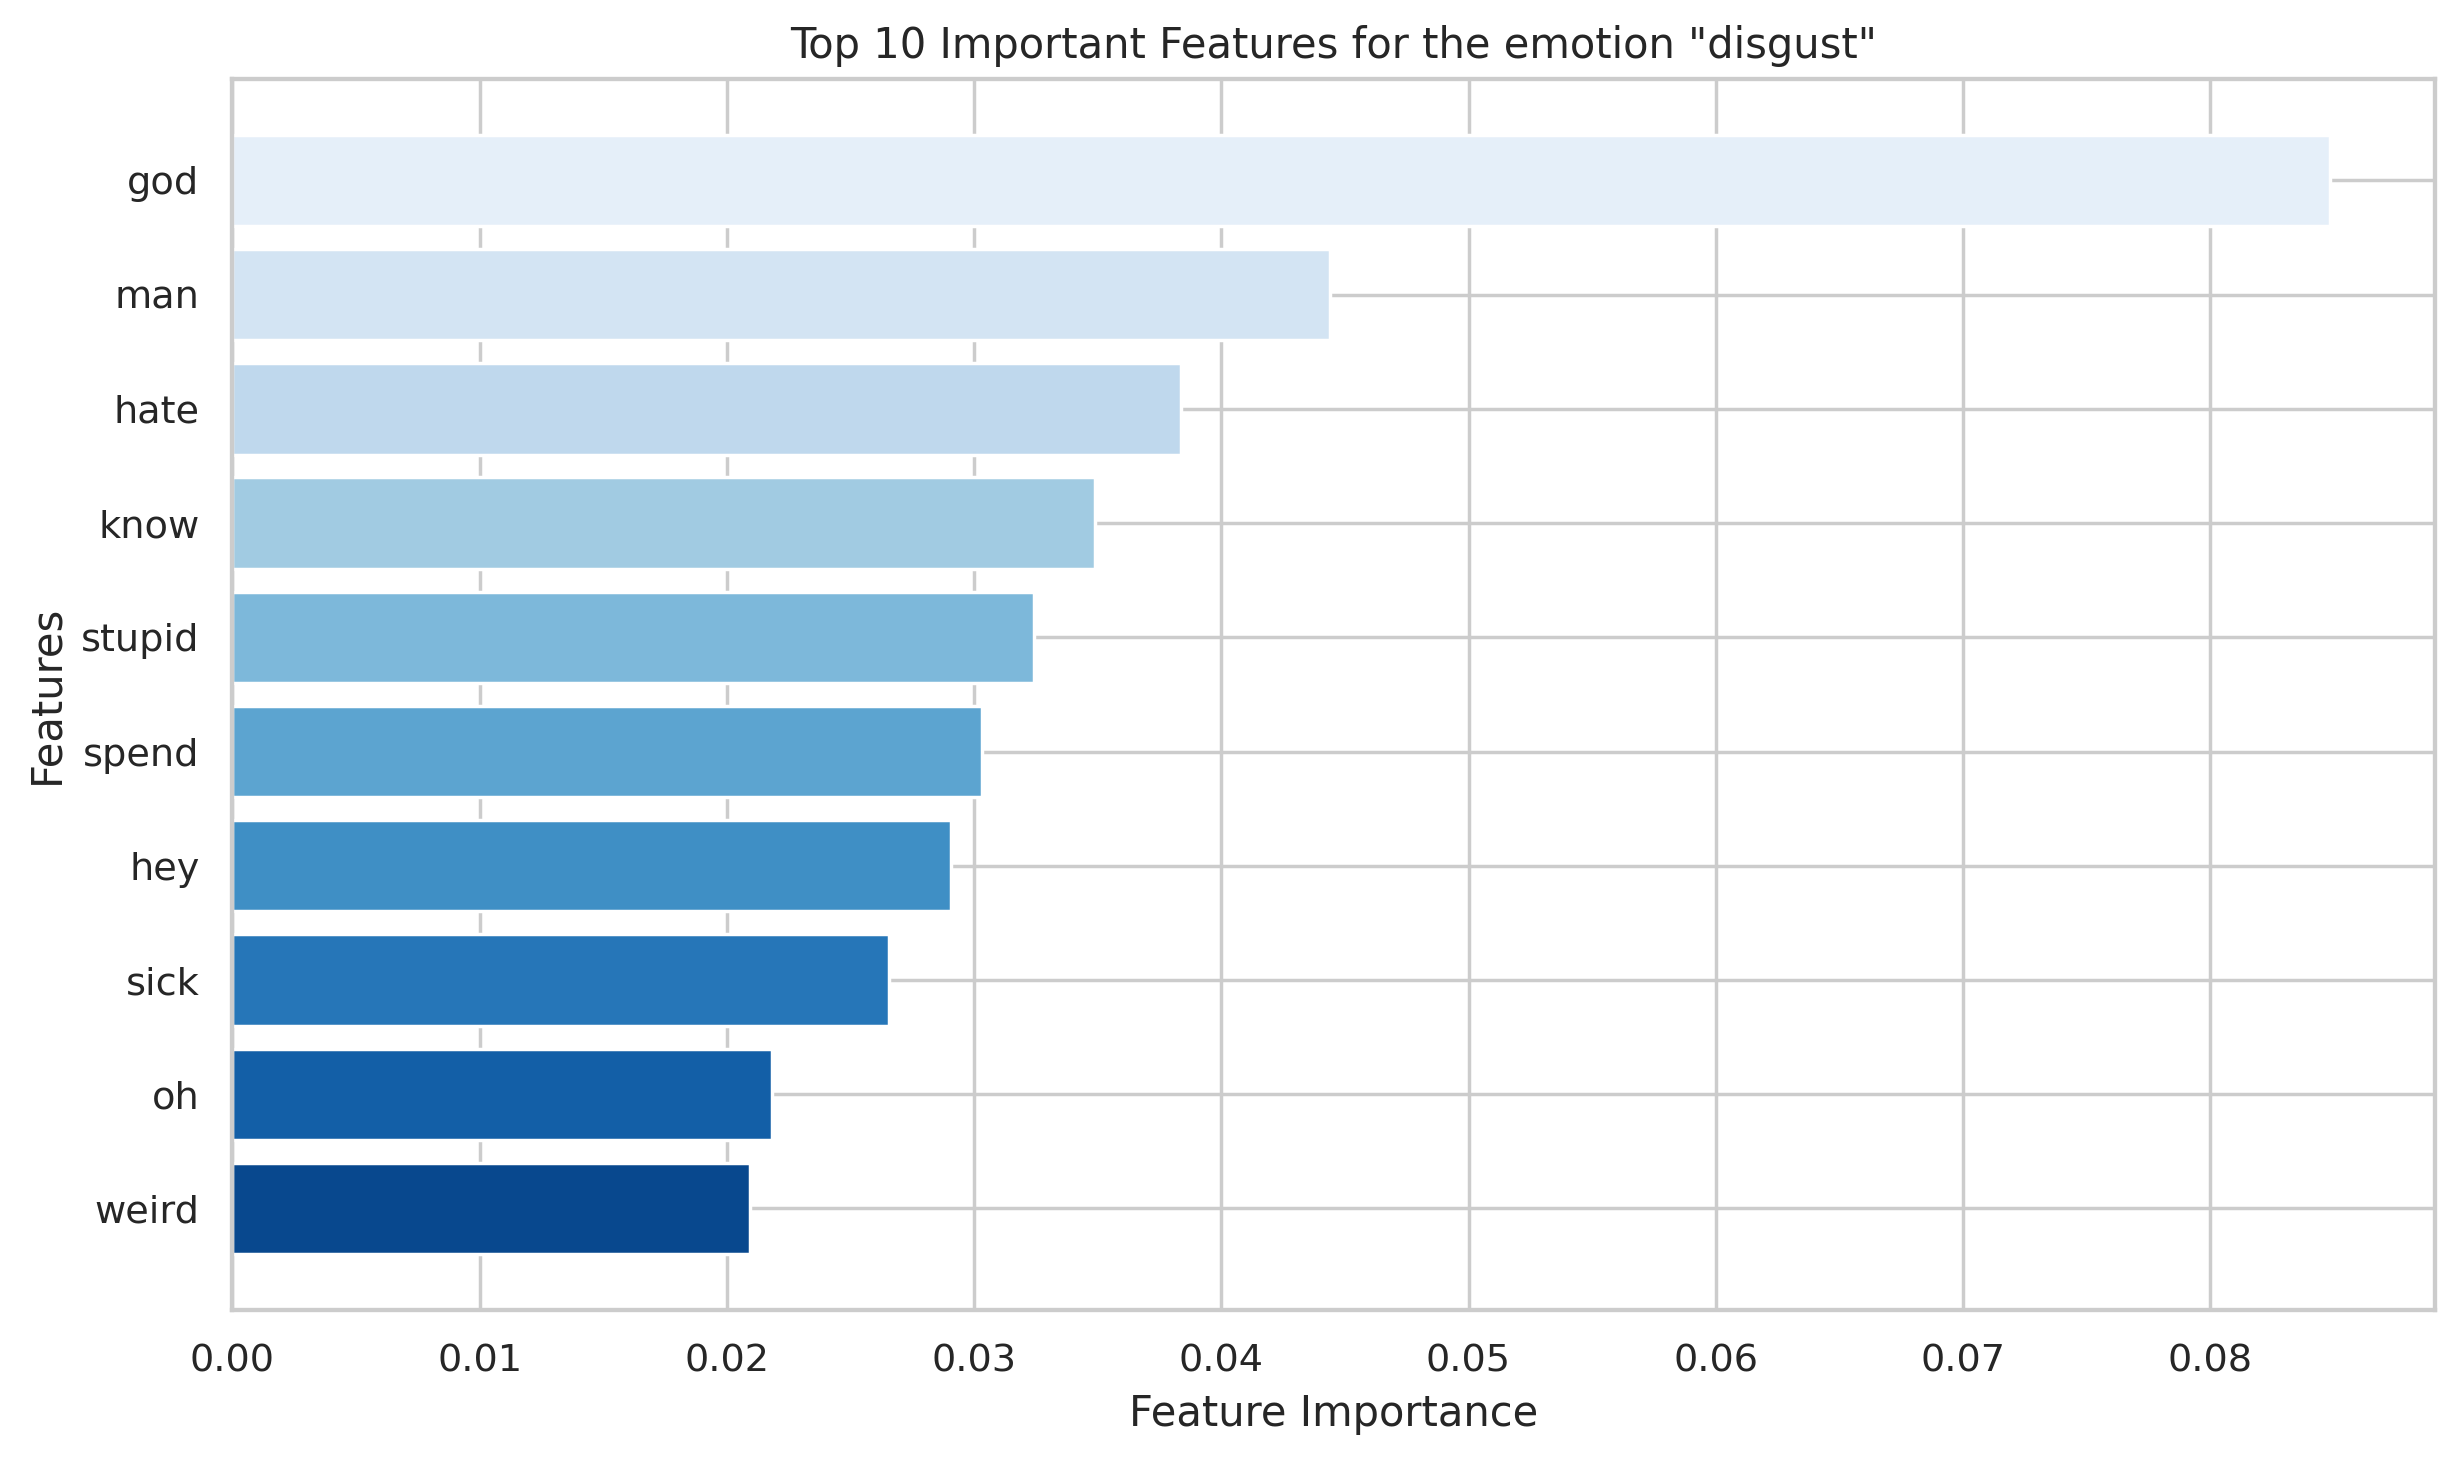

In [ ]:
feature_names, importances = zip(*features[:10])
plt.figure(figsize=(10, 6), dpi = 250)

colors = sns.color_palette('Blues', n_colors = len(feature_names))
plt.barh(feature_names, importances, color = colors)

plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Important Features for the emotion "disgust"')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

In [ ]:
from wordcloud import WordCloud

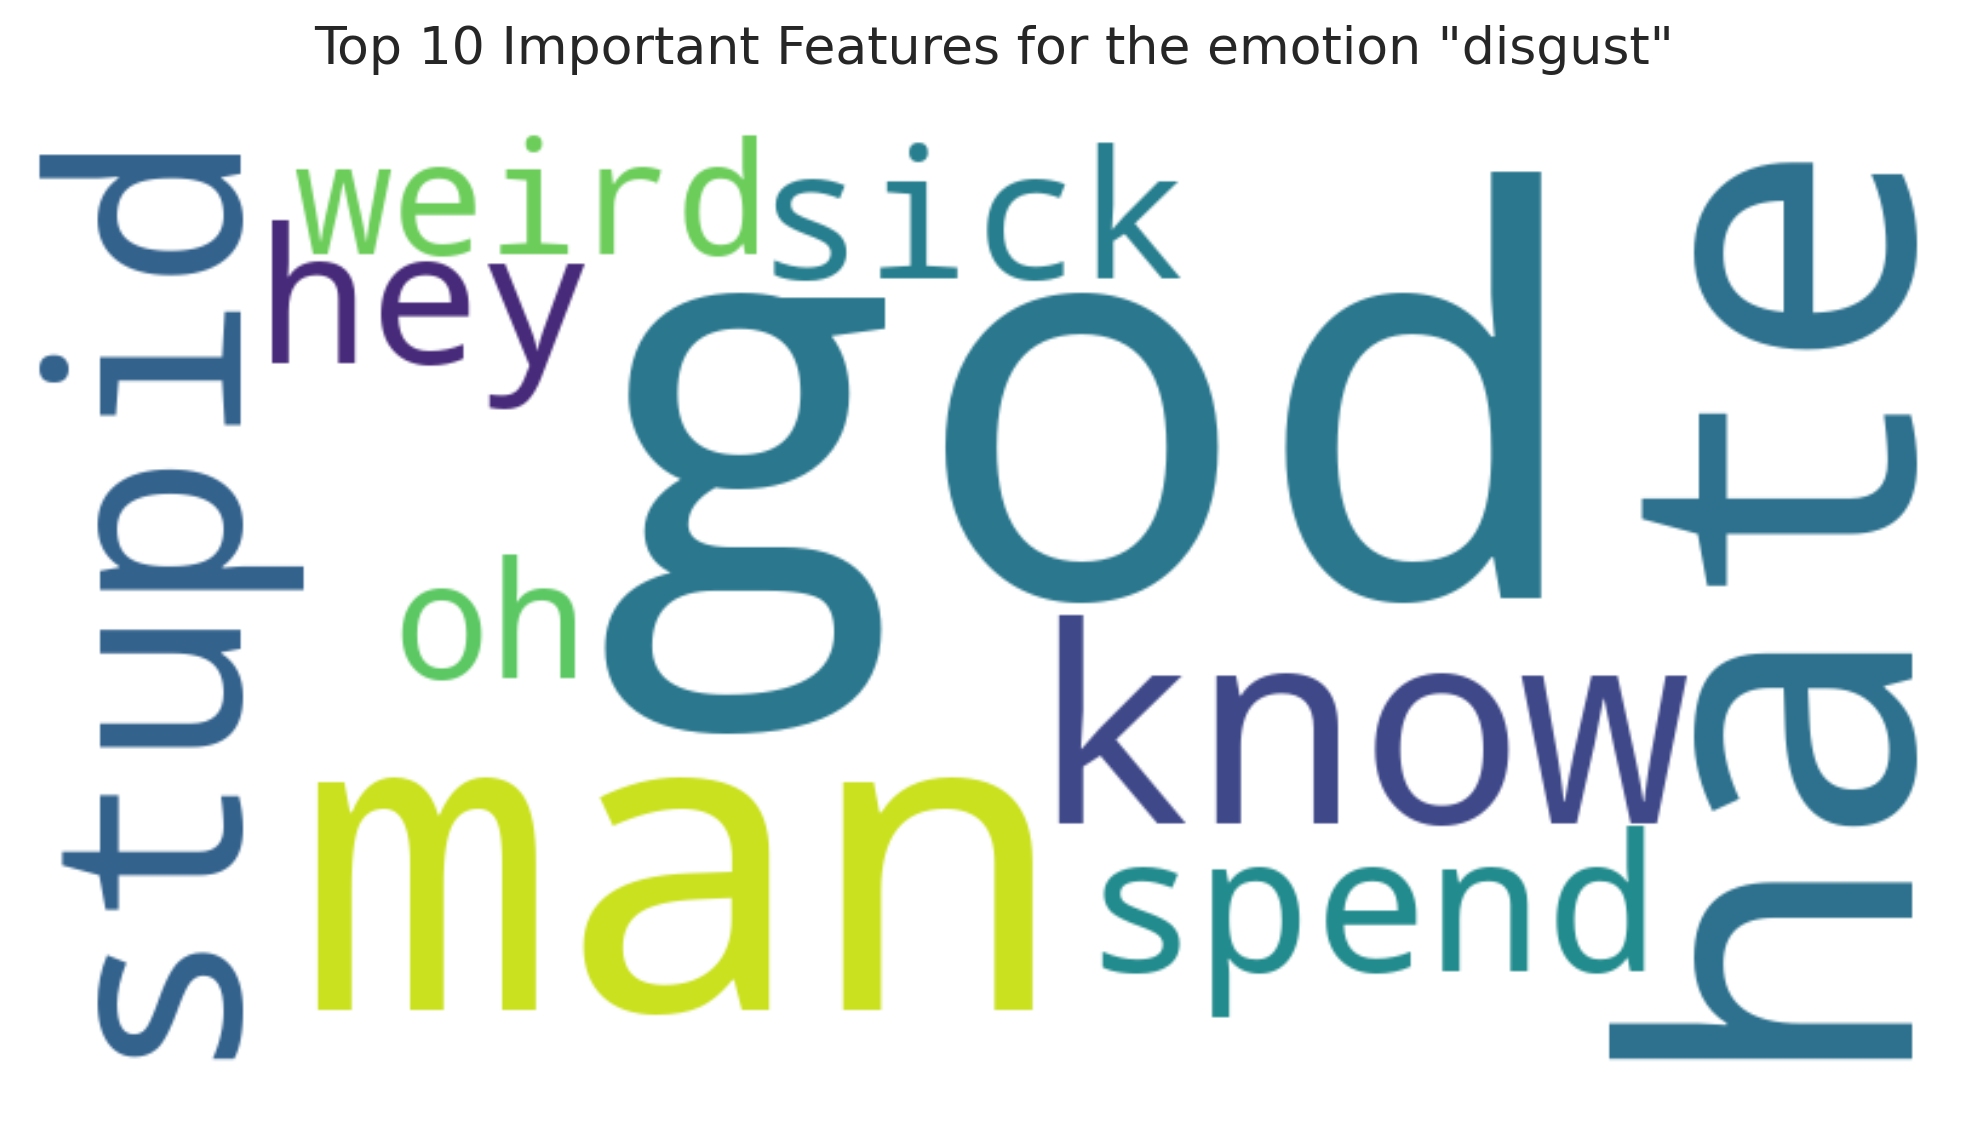

In [ ]:
word_freq = dict(zip(feature_names, importances))
# print(word_freq)

wordcloud = WordCloud(width = 800, height = 400, background_color = 'white', prefer_horizontal = 0.6)

wordcloud.generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 6), dpi = 250)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title('Top 10 Important Features for the emotion "disgust"', fontsize = 15, pad = 20)
plt.axis('off')
plt.show()

## Multi-class classification

In [ ]:
train = data[data.split == 'train']
dev = data[data.split == 'dev']
test = data[data.split == 'test']
new_train = data[data.split.isin(['train', 'dev'])]

X_train = train['clean']
y_train = train['y']

X_dev = dev['clean']
y_dev = dev['y']

X_test = test['clean']
y_test = test['y']

X_new_train = new_train['clean']
y_new_train = new_train['y']

vectorizer = TfidfVectorizer(stop_words = 'english', max_features = 1000)
X_train = vectorizer.fit_transform(X_train)

X_dev = vectorizer.transform(X_dev)
X_test = vectorizer.transform(X_test)
X_new_train = vectorizer.transform(X_new_train)

### Decision Tree

In [ ]:
best_f1 = 0
best_params = {}
criterion_lst = ['gini', 'entropy']
depth_lst = [5, 10, 15, 20]
weight_lst = [None, 'balanced']
sample_lst = [2, 5, 10]

for criterion in criterion_lst:
  for depth in depth_lst:
      for weight in weight_lst:
        for sample in sample_lst:
          model = DecisionTreeClassifier(max_depth = depth, criterion = criterion, class_weight = weight, min_samples_split = sample)
          model.fit(X_train, y_train)
          y_pred = model.predict(X_dev)
          acc = accuracy_score(y_dev, y_pred)
          f1 = f1_score(y_dev, y_pred, average = 'macro')
          # print('criterion:', criterion, 'max_depth:', depth, 'class_weight:', weight, 'Accuracy:', 'min_samples_split', sample, acc, 'F1-score:', f1)
          if f1 > best_f1:
              best_f1 = f1
              best_params = {'criterion': criterion, 'max_depth': depth, 'class_weight': weight, 'min_samples_split': sample}
print(best_params)


{'criterion': 'gini', 'max_depth': 20, 'class_weight': None, 'min_samples_split': 2}


In [ ]:
final_dt = DecisionTreeClassifier(**best_params)
final_dt.fit(X_new_train, y_new_train)
y_pred_dt = final_dt.predict(X_test)
f1_dt = f1_score(y_test, y_pred_dt, average = 'macro')
acc_dt = accuracy_score(y_test, y_pred_dt)
pre_dt = precision_score(y_test, y_pred_dt, average = 'macro')
print('Accuracy:', acc_dt, 'Precision:', pre_dt, 'F1-score:', f1_dt)

Accuracy: 0.48314176245210727 Precision: 0.32393678546221005 F1-score: 0.2106402366601197


In [ ]:
feature_importances = final_dt.feature_importances_
feature_names = vectorizer.get_feature_names_out()
features = list(zip(feature_names, feature_importances))
features.sort(key = lambda x: -x[1])
for feature, importance in features[:10]:
    print(f"{feature}: {importance}")

god: 0.059851342656373825
don: 0.05852139021643902
sorry: 0.054039176455467935
oh: 0.052305300277966676
great: 0.04131535044057139
really: 0.03797108073349403
love: 0.032605411855258955
wow: 0.030138719477223956
okay: 0.0266502936899988
yeah: 0.02307327068193488


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

best_f1 = 0
best_params = {}

n_estimators_list = [10, 50, 100]
criterion_list = ['gini', 'entropy']
max_depth_list = [5, 10, 15, None]
min_samples_split_list = [2, 5, 10]

for n_estimators in n_estimators_list:
    for criterion in criterion_list:
        for max_depth in max_depth_list:
            for min_samples_split in min_samples_split_list:
                model = RandomForestClassifier(n_estimators = n_estimators, criterion = criterion, max_depth = max_depth,
                                min_samples_split = min_samples_split, class_weight = 'balanced')
                model.fit(X_train, y_train)
                y_pred = model.predict(X_dev)

                acc = accuracy_score(y_dev, y_pred)
                f1 = f1_score(y_dev, y_pred, average='macro')

                # print(f'N_estimators: {n_estimators}, Criterion: {criterion}, Max_depth: {max_depth}, Min_samples_split: {min_samples_split}, Accuracy: {acc:.4f}, F1-score: {f1:.4f}')

                if f1 > best_f1:
                    best_f1 = f1
                    best_params = {'n_estimators': n_estimators, 'criterion': criterion, 'max_depth': max_depth, 'min_samples_split': min_samples_split}
print('Best F1 Score:', best_f1)
print('Best Parameters:', best_params)


final_rf = RandomForestClassifier(**best_params)
final_rf.fit(X_new_train, y_new_train)
y_pred_rf = final_rf.predict(X_test)
f1_rf = f1_score(y_test, y_pred_rf, average = 'macro')
acc_rf = accuracy_score(y_test, y_pred_rf)
pre_rf = precision_score(y_test, y_pred_rf, average = 'macro')
print('Accuracy:', acc_rf, 'Precision:', pre_rf, 'F1-score:', f1_rf)

feature_importances = final_rf.feature_importances_
feature_names = vectorizer.get_feature_names_out()
features = list(zip(feature_names, feature_importances))
features.sort(key = lambda x: -x[1])
for feature, importance in features[:10]:
    print(f"{feature}: {importance}")

Best F1 Score: 0.2761096946976942
Best Parameters: {'n_estimators': 100, 'criterion': 'gini', 'max_depth': None, 'min_samples_split': 5}
Accuracy: 0.39655172413793105 Precision: 0.2618910108043185 F1-score: 0.25281096302040834
oh: 0.019430231979880596
sorry: 0.013505638930379368
okay: 0.013098335346161498
really: 0.01305229659087281
know: 0.011818097550096308
don: 0.011721860823264416
just: 0.010623751097204195
yeah: 0.010098568088600343
god: 0.009858513149419426
gonna: 0.009578363407337137


### Comparison

Comparing the two different models for multiclass classification task, the Decision Tree model outperformed Random Forest model on accuracy and precision, but the F1-score of RF model is higher.

The higher F1-score means that RF might perform better in terms of recall, and it might have better performance in identifying more positive samples, although it may result in lower precision due to more false positive samples being predicted as well.

Besides, as an ensemble model, Random Forest improves the predict stability as it integrates the prediction results from many weak classifiers. This approach can often improve the overall perforance of the model and reduce the issue of over fitting.

The dataset we use is a bit imblanced, which means a smaller number of sample classes will have a greater impact on the model's learning process. Random forests may perform better on some hard-to-identify classes in a way that improves the overall F1-score.